<a href="https://colab.research.google.com/github/Gurpremm/Intro-to-deep-learning/blob/master/digits_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST digits classification with TensorFlow

In [0]:
! shred -u setup_google_colab.py
! wget https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/setup_google_colab.py -O setup_google_colab.py
import setup_google_colab
# please, uncomment the week you're working on
# setup_google_colab.setup_week1()
setup_google_colab.setup_week2()
# setup_google_colab.setup_week3()
# setup_google_colab.setup_week4()
# setup_google_colab.setup_week5()
# setup_google_colab.setup_week6()

# If you're using the old version of the course (check a path of notebook on Coursera, you'll see v1 or v2),
# use setup_week2_old().

--2019-01-05 07:40:33--  https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/setup_google_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3792 (3.7K) [text/plain]
Saving to: ‘setup_google_colab.py’

setup_google_colab. 100%[===================>]   3.70K  --.-KB/s    in 0s      

2019-01-05 07:40:33 (39.1 MB/s) - ‘setup_google_colab.py’ saved [3792/3792]

**************************************************
inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
**************************************************
cifar-10-batches-py.tar.gz
**************************************************
mnist.npz


<img src="https://github.com/hse-aml/intro-to-dl/blob/master/week2/v2/images/mnist_sample.png?raw=1" style="width:30%">

In [0]:
import numpy as np
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
%matplotlib inline
import tensorflow as tf
print("We're using TF", tf.__version__)

import sys
sys.path.append("../..")
import grading

import matplotlib_utils
from importlib import reload
reload(matplotlib_utils)

import grading_utils
reload(grading_utils)

import keras_utils
from keras_utils import reset_tf_session

We're using TF 1.12.0


Using TensorFlow backend.


# Fill in your Coursera token and email
To successfully submit your answers to our grader, please fill in your Coursera submission token and email

In [0]:
grader = grading.Grader(assignment_key="XtD7ho3TEeiHQBLWejjYAA", 
                        all_parts=["9XaAS", "vmogZ", "RMv95", "i8bgs", "rE763"])

In [0]:
# token expires every 30 min
COURSERA_TOKEN = "GGfXi4UwA5y396AH"
COURSERA_EMAIL = "gurpremsingh94@gmail.com"

# Look at the data

In this task we have 50000 28x28 images of digits from 0 to 9.
We will train a classifier on this data.

In [0]:
import preprocessed_mnist
X_train, y_train, X_val, y_val, X_test, y_test = preprocessed_mnist.load_dataset()

X_train [shape (50000, 28, 28)] sample patch:
 [[0.         0.29803922 0.96470588 0.98823529 0.43921569]
 [0.         0.33333333 0.98823529 0.90196078 0.09803922]
 [0.         0.33333333 0.98823529 0.8745098  0.        ]
 [0.         0.33333333 0.98823529 0.56862745 0.        ]
 [0.         0.3372549  0.99215686 0.88235294 0.        ]]
A closeup of a sample patch:


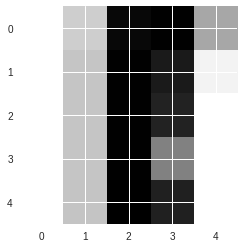

And the whole sample:


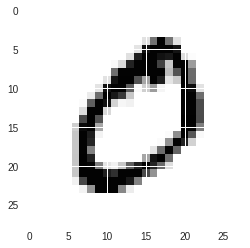

y_train [shape (50000,)] 10 samples:
 [5 0 4 1 9 2 1 3 1 4]


In [0]:
# X contains rgb values divided by 255
print("X_train [shape %s] sample patch:\n" % (str(X_train.shape)), X_train[1, 15:20, 5:10])
print("A closeup of a sample patch:")
plt.imshow(X_train[1, 15:20, 5:10], cmap="Greys")
plt.show()
print("And the whole sample:")
plt.imshow(X_train[1], cmap="Greys")
plt.show()
print("y_train [shape %s] 10 samples:\n" % (str(y_train.shape)), y_train[:10])

# Linear model

Your task is to train a linear classifier $\vec{x} \rightarrow y$ with SGD using TensorFlow.

You will need to calculate a logit (a linear transformation) $z_k$ for each class: 
$$z_k = \vec{x} \cdot \vec{w_k} + b_k \quad k = 0..9$$

And transform logits $z_k$ to valid probabilities $p_k$ with softmax: 
$$p_k = \frac{e^{z_k}}{\sum_{i=0}^{9}{e^{z_i}}} \quad k = 0..9$$

We will use a cross-entropy loss to train our multi-class classifier:
$$\text{cross-entropy}(y, p) = -\sum_{k=0}^{9}{\log(p_k)[y = k]}$$ 

where 
$$
[x]=\begin{cases}
       1, \quad \text{if $x$ is true} \\
       0, \quad \text{otherwise}
    \end{cases}
$$

Cross-entropy minimization pushes $p_k$ close to 1 when $y = k$, which is what we want.

Here's the plan:
* Flatten the images (28x28 -> 784) with `X_train.reshape((X_train.shape[0], -1))` to simplify our linear model implementation
* Use a matrix placeholder for flattened `X_train`
* Convert `y_train` to one-hot encoded vectors that are needed for cross-entropy
* Use a shared variable `W` for all weights (a column $\vec{w_k}$ per class) and `b` for all biases.
* Aim for ~0.93 validation accuracy

In [0]:
X_train_flat = X_train.reshape((X_train.shape[0], -1))
print(X_train_flat.shape)

X_val_flat = X_val.reshape((X_val.shape[0], -1))
print(X_val_flat.shape)

(50000, 784)
(10000, 784)


In [0]:
import keras

y_train_oh = keras.utils.to_categorical(y_train, 10)
y_val_oh = keras.utils.to_categorical(y_val, 10)

print(y_train_oh.shape)
print(y_train_oh[:3], y_train[:3])

(50000, 10)
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]] [5 0 4]


In [0]:
# run this again if you remake your graph
s = reset_tf_session()

In [0]:
# Model parameters: W and b
#W = ### YOUR CODE HERE ### tf.get_variable(...) with shape[0] = 784
W=tf.Variable(initial_value=np.random.randn(X_train_flat.shape[1], 10)*0.01, name="weights", dtype="float32")
print(W.shape)
#b = ### YOUR CODE HERE ### tf.get_variable(...)
#b = tf.get_variable(name="b",shape=(), dtype="float32",aggregation=tf.VariableAggregation.NONE)
#b=tf.Variable(np.ones(10), name="b", dtype="float32")
b = tf.get_variable("b",shape=(10,), dtype=tf.float32)

print(b.shape)
#W = tf.Variable(tf.random_normal(shape=(X_train.shape[0],1), stddev=0.01, dtype=tf.float32))
#b = tf.Variable(0.0, dtype=tf.float32)

(784, 10)
(10,)


In [0]:
# Placeholders for the input data
#input_X = ### YOUR CODE HERE ### tf.placeholder(...) for flat X with shape[0] = None for any batch size
#input_y = ### YOUR CODE HERE ### tf.placeholder(...) for one-hot encoded true labels

input_X = tf.placeholder(tf.float32, name="input_X",shape=(None,784))
input_y = tf.placeholder(tf.float32, name="input_y",shape=(None,10))

In [0]:
# Compute predictions
#logits = ### YOUR CODE HERE ### logits for input_X, resulting shape should be [input_X.shape[0], 10]
#probas = ### YOUR CODE HERE ### apply tf.nn.softmax to logits
#classes = ### YOUR CODE HERE ### apply tf.argmax to find a class index with highest probability

#hidden1=tf.layers.dense(input_X,256,activation=tf.nn.sigmoid)
#hidden1=tf.layers.dense(hidden1,256,activation=tf.nn.sigmoid)
logits=(tf.matmul(input_X, W)+ b)
#logits = tf.dense(hidden2,10)
print(logits.shape, input_X.shape, W.shape,input_y.shape)
probas = tf.nn.softmax(logits)
classes = tf.argmax(probas,axis=1)
print(classes.shape)
#predicted_y = tf.squeeze(tf.sigmoid(tf.matmul(input_X, W) + b))
# Loss should be a scalar number: average loss over all the objects with tf.reduce_mean().
# Use tf.nn.softmax_cross_entropy_with_logits on top of one-hot encoded input_y and logits.
# It is identical to calculating cross-entropy on top of probas, but is more numerically friendly (read the docs).
#loss = ### YOUR CODE HERE ### cross-entropy loss
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=input_y,logits=logits))

# Use a default tf.train.AdamOptimizer to get an SGD step
#step = ### YOUR CODE HERE ### optimizer step that minimizes the loss
step = tf.train.AdamOptimizer(0.01).minimize(loss)

(?, 10) (?, ?) (784, 10) (?, 10)
(?,)


In [0]:
s.run(tf.global_variables_initializer())

BATCH_SIZE = 512
EPOCHS = 40

# for logging the progress right here in Jupyter (for those who don't have TensorBoard)
simpleTrainingCurves = matplotlib_utils.SimpleTrainingCurves("cross-entropy", "accuracy")

for epoch in range(EPOCHS):  # we finish an epoch when we've looked at all training samples
    
    batch_losses = []
    for batch_start in range(0, X_train_flat.shape[0], BATCH_SIZE):  # data is already shuffled
        _, batch_loss = s.run([step, loss], {input_X: X_train_flat[batch_start:batch_start+BATCH_SIZE], 
                                             input_y: y_train_oh[batch_start:batch_start+BATCH_SIZE]})
        # collect batch losses, this is almost free as we need a forward pass for backprop anyway
        batch_losses.append(batch_loss)

    train_loss = np.mean(batch_losses)
    val_loss = s.run(loss, {input_X: X_val_flat, input_y: y_val_oh})  # this part is usually small
    train_accuracy = accuracy_score(y_train, s.run(classes, {input_X: X_train_flat}))  # this is slow and usually skipped
    valid_accuracy = accuracy_score(y_val, s.run(classes, {input_X: X_val_flat}))  
    simpleTrainingCurves.add(train_loss, val_loss, train_accuracy, valid_accuracy)

<img src="%2BTl5ufo6erx8vP09fb3%2BPn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3%2BPn6/9oADAMBAAIRAxEAPwD9/KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDxPxd/wAFFP2PvAmoXmn%2BK/ipc2gs9UbTReHwpqj2l5eLfw6fJb2lwlsYb2SO7nigkW3eQxOxD7drY2j%2B2f8As6R%2BObL4c3XjHUbfVLy6sLNlu/Cmpw29le3sUctpY3dw9sIbG8lSWIraXDxzkzRjy8uoPiVz%2Bxn%2B1bH4C8N/s66Zqfw9HgXwn8W9N8V22tXOo3r6rqtnb%2BLrXWxbyQC1EVrLHAlxFvEswuJFiJ%2Bzqzbeh8cfsffGzXfGPi3wPoup%2BFv%2BEA8c/F7QfHuq61dalcrrOnvp8mlTyWEVqtu0Mwll0mLbcNcRmJLhh5TmNSwB6Fa/t1fsv3cGr3w8f30Nno2n3N7LqV54U1OC0vYLedLeZ7G4ktli1HbNJHHi1aYlpEAB3rns/hT8ZfAXxp0m91fwJc6njTdQNlqVnrfh690q8tJxGkuyW1voYZ48xyxupZAGVwQSDmvmbTf2IPj5a6t4mtbTwl8ONN8MazoOp22reBV8Za1feHfFN5cXcEsdw2mTwCPQGCJcEvZyTnzLkMRL5Q3egfs4/sm%2BOvDGmXP/AAu3xl4hhgsfFa6n4L8M6H8ZPEOpQaLbC3tla2mvpmtZtTheeGSUQXUbxRLKY1BQnIB0kX7eP7Kk0fiC6HxNlW18N6Jqur32oy%2BHdQS0urLTSRfzWVw1uItSFuRiQWjTFSQCMkZ5vx3/AMFL/wBmXwh4Vl8TaPd%2BJtceDxF4b0yXTdP8Dav9qeLW78WdnfwxNaB7m1crO0c8IeOZoTFEzyvGjeKaH/wSx%2BI%2BjfBrXPgl5eiXX9m/DfxR4c8C%2BK9W%2BK/ia/LzajZT2VtI%2Bkz5sdLUQzFZjALjJGY0j4A7z4//ALEPxs8d%2BOH%2BIfw%2B1Pwo9zp/hz4cxaTp2r6nc20dzfeG/FE2szxSyRW0phhlidIklVJGDliYsAbgD1V/25/2ZFtteu4/G%2BpzJ4b8Sf8ACPakLbwfqsrPq/nPCdOt1S1JvLsOhJggEkgQrIV2MrGpqn/BQX9lDSbTRp5PH%2Bq3U%2Bv2Wq3WmaXpfgnWLy/ZNMuIrfUFks4LR7iGW3lmRZIpI1kT5iVwjleFtv2OvjToXha08QaFfeFZvFegftCaz8R9G0y61O5j0%2B%2Bgvl1C3NnPcrbNJDILbUZSJFhlCyxJ8rCvMNI%2BEf7S3wX/AG5vCGqeD9N8Dav478U%2BA/iX4l1jSNT128tdItftmt%2BFwlvBdpZyzN5Srb5kNuvnFZfli8wbQD6jsf2yP2adU8Gaz8QtK%2BKVvd6PoNxpMGoXtpY3MoLapDaTaeYVWMtcrcJfWvlvCHVmkKZ3I6r6bXwN8Nv2Q7XwR%2B1Z8Ff2dvBXxLsNdsPh58M9Ff432dmnD3ugLu8PPKqki2klutRnuUjf52i06PGVQGvvmgAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArzb4q/tdfs/fBPxlH4D%2BJPje4stR%2By2l1efZ9Bvru3023urh7a2nvbi3geGwilmjkRJLl41YxvgnY2PSa%2BQ/28f2Kv2o/2pNZ8Z6N4R%2BIWn/8I5rvhC0s/DFtqHxB1rSoNGvoXnkm8/TtPi8jU47ljApluZG8hVJWCXbscA9gh/br/ZUku9btpviqtrFoGn6hfXeoahot7bWVzb2EywXslndSwrDqAhldI3%2ByvKVd1U8sAdDwJ%2B2B%2Bz78R/EmneC/DXjC%2Bj1vVNTutPt9D1fwzqOnX0Vzb2kd5LHPb3dvHLbH7NLHMvnKgkSRShbIrwzQ/wBjX9rW8/ZXP7IXiDWvh5pWgaLpEn9ga1ZX99qF3qF9FqUN9YC5R7e3W2hjMRinKNO1xuDqIOYz1/jH4S/tp%2BNfiB4H%2BPWqaH8ME1/wZ4l1CS08HQeJtQWzGmXel/ZHLambAyTXAnHnAfY408s%2BVnK%2BawB2uh/t0/steJddsPDmh/EuW4utR0KfWotnh7UBFDpsM9zbzXk8pg8u1gSa0njaSZkUMEBP72Le3w9%2B3Z%2By74m8J6741sviFe21l4dsdPvdSj1fwrqdhctbX8jRWM0Ftc20c13Hcyq0UDQJIJpAUjLN8teO/s%2BfsI/tK/Bjw3q7xfFHwvY%2BKLj4J3fhXR/EWlxzSrY61Jq2rX0V6IZYgDAn263baWJ3RuuCAGbkrH/gnN%2B1HceNNR%2BImoa74div59G8Iz2dvrXxT1/xIw1jw7r39rQrLc6hbB/st3vlR/JSJbU7WjgmJY0AfUHw9/bC/Z2%2BJ%2Buy%2BF/Cnj%2BRdTttLvdQvdN1fRL3Tbizgs5Yorrz47uGJoHia4ty8UgWRVnicrskRj2nw98e%2BFvip4C0T4m%2BBr%2BS70XxFpNvqWkXU1nLbtNazxrLE5imVJIyUZTtdVYZwQDxXxx%2B3H8PfjP8Ybb4c/D3xh4x8IaH8UvFXjTUNFj8PeD724unh8D6lZNaa0vnSpDLMYoUS7N2YYIxPDbRBdxQyfbOnadYaRp8Gk6XZx29rawrDbW8KBUijUAKqgcAAAAD2oAmooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKzPFWs3eh6el3aJGzNMEIkUkYwT2I9K068t%2BMfxYfQvjP4P%2BCbaUjR%2BJfDut6v9uMpDRPp82mxCILjBDrqLsTnjyQMHdwueEJR59m0vm9EdOGwmIxspRoq7jGU3/hhHmk/ktbbvodB/wsPWv%2BfW1/74b/4qj/hYetf8%2Btr/AN8N/wDFVg0V3ezh2OO7N7/hYetf8%2Btr/wB8N/8AFUf8LD1r/n1tf%2B%2BG/wDiqwaKPZw7BdnSP471hdPiuxb2255pEI2NjChCP4v9o1D/AMLD1r/n1tf%2B%2BG/%2BKrLm/wCQLb/9fU3/AKDFVWkqcOwXZvf8LD1r/n1tf%2B%2BG/wDiqP8AhYetf8%2Btr/3w3/xVYNFP2cOwXZvf8LD1r/n1tf8Avhv/AIqprrx3rEEFvKtvbEzQl2yjcHey/wB7/ZFc3VrUP%2BPSx/69T/6NkpOnC%2BwXZqf8LD1r/n1tf%2B%2BG/wDiqP8AhYetf8%2Btr/3w3/x

# Submit a linear model

In [0]:
## GRADED PART, DO NOT CHANGE!
# Testing shapes 
grader.set_answer("9XaAS", grading_utils.get_tensors_shapes_string([W, b, input_X, input_y, logits, probas, classes]))
# Validation loss
grader.set_answer("vmogZ", s.run(loss, {input_X: X_val_flat, input_y: y_val_oh}))
# Validation accuracy
grader.set_answer("RMv95", accuracy_score(y_val, s.run(classes, {input_X: X_val_flat})))

In [0]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!


# MLP with hidden layers

In [0]:
s=reset_tf_session()

Previously we've coded a dense layer with matrix multiplication by hand. 
But this is not convenient, you have to create a lot of variables and your code becomes a mess. 
In TensorFlow there's an easier way to make a dense layer:
```python
hidden1 = tf.layers.dense(inputs, 256, activation=tf.nn.sigmoid)
```

That will create all the necessary variables automatically.
Here you can also choose an activation function (remember that we need it for a hidden layer!).

Now define the MLP with 2 hidden layers and restart training with the cell above.

You're aiming for ~0.97 validation accuracy here.

In [0]:
#from tf import layers.dense
# write the code here to get a new `step` operation and then run the cell with training loop above.
# name your variables in the same way (e.g. logits, probas, classes, etc) for safety.
### YOUR CODE HERE ###
s.run(tf.global_variables_initializer())
hidden1=tf.layers.dense(input_X,256,activation=tf.nn.sigmoid)
hidden2=tf.layers.dense(hidden1,256,activation=tf.nn.sigmoid)
#logits=(tf.matmul(input_X, W)+ b)
#model = tf.keras.models.Sequential()
#a=tf.keras.layers.Dense(256, "sigmoid")
#h=tf.keras.layers.Dense(256, "sigmoid")
logits = tf.layers.dense(hidden2,10)
print(logits.shape, input_X.shape, W.shape,input_y.shape)
probas = tf.nn.softmax(logits)
classes = tf.argmax(probas,axis=1)
print(classes.shape)
#predicted_y = tf.squeeze(tf.sigmoid(tf.matmul(input_X, W) + b))
# Loss should be a scalar number: average loss over all the objects with tf.reduce_mean().
# Use tf.nn.softmax_cross_entropy_with_logits on top of one-hot encoded input_y and logits.
# It is identical to calculating cross-entropy on top of probas, but is more numerically friendly (read the docs).
#loss = ### YOUR CODE HERE ### cross-entropy loss
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=input_y,logits=logits))

# Use a default tf.train.AdamOptimizer to get an SGD step
#step = ### YOUR CODE HERE ### optimizer step that minimizes the loss
step = tf.train.AdamOptimizer(0.001).minimize(loss)

(?, 10) (?, 784) (784, 10) (?, 10)
(?,)


In [0]:
s.run(tf.global_variables_initializer())

BATCH_SIZE = 512
EPOCHS = 40

# for logging the progress right here in Jupyter (for those who don't have TensorBoard)
simpleTrainingCurves = matplotlib_utils.SimpleTrainingCurves("cross-entropy", "accuracy")

for epoch in range(EPOCHS):  # we finish an epoch when we've looked at all training samples
    
    batch_losses = []
    for batch_start in range(0, X_train_flat.shape[0], BATCH_SIZE):  # data is already shuffled
        _, batch_loss = s.run([step, loss], {input_X: X_train_flat[batch_start:batch_start+BATCH_SIZE], 
                                             input_y: y_train_oh[batch_start:batch_start+BATCH_SIZE]})
        # collect batch losses, this is almost free as we need a forward pass for backprop anyway
        batch_losses.append(batch_loss)

    train_loss = np.mean(batch_losses)
    val_loss = s.run(loss, {input_X: X_val_flat, input_y: y_val_oh})  # this part is usually small
    train_accuracy = accuracy_score(y_train, s.run(classes, {input_X: X_train_flat}))  # this is slow and usually skipped
    valid_accuracy = accuracy_score(y_val, s.run(classes, {input_X: X_val_flat}))  
    simpleTrainingCurves.add(train_loss, val_loss, train_accuracy, valid_accuracy)

<img src="%2BTl5ufo6erx8vP09fb3%2BPn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3%2BPn6/9oADAMBAAIRAxEAPwD9/KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDxPxd/wAFFP2PvAmoXmn%2BK/ipc2gs9UbTReHwpqj2l5eLfw6fJb2lwlsYb2SO7nigkW3eQxOxD7drY2j%2B2f8As6R%2BObL4c3XjHUbfVLy6sLNlu/Cmpw29le3sUctpY3dw9sIbG8lSWIraXDxzkzRjy8uoPiVz%2Bxn%2B1bH4C8N/s66Zqfw9HgXwn8W9N8V22tXOo3r6rqtnb%2BLrXWxbyQC1EVrLHAlxFvEswuJFiJ%2Bzqzbeh8cfsffGzXfGPi3wPoup%2BFv%2BEA8c/F7QfHuq61dalcrrOnvp8mlTyWEVqtu0Mwll0mLbcNcRmJLhh5TmNSwB6Fa/t1fsv3cGr3w8f30Nno2n3N7LqV54U1OC0vYLedLeZ7G4ktli1HbNJHHi1aYlpEAB3rns/hT8ZfAXxp0m91fwJc6njTdQNlqVnrfh690q8tJxGkuyW1voYZ48xyxupZAGVwQSDmvmbTf2IPj5a6t4mtbTwl8ONN8MazoOp22reBV8Za1feHfFN5cXcEsdw2mTwCPQGCJcEvZyTnzLkMRL5Q3egfs4/sm%2BOvDGmXP/AAu3xl4hhgsfFa6n4L8M6H8ZPEOpQaLbC3tla2mvpmtZtTheeGSUQXUbxRLKY1BQnIB0kX7eP7Kk0fiC6HxNlW18N6Jqur32oy%2BHdQS0urLTSRfzWVw1uItSFuRiQWjTFSQCMkZ5vx3/AMFL/wBmXwh4Vl8TaPd%2BJtceDxF4b0yXTdP8Dav9qeLW78WdnfwxNaB7m1crO0c8IeOZoTFEzyvGjeKaH/wSx%2BI%2BjfBrXPgl5eiXX9m/DfxR4c8C%2BK9W%2BK/ia/LzajZT2VtI%2Bkz5sdLUQzFZjALjJGY0j4A7z4//ALEPxs8d%2BOH%2BIfw%2B1Pwo9zp/hz4cxaTp2r6nc20dzfeG/FE2szxSyRW0phhlidIklVJGDliYsAbgD1V/25/2ZFtteu4/G%2BpzJ4b8Sf8ACPakLbwfqsrPq/nPCdOt1S1JvLsOhJggEkgQrIV2MrGpqn/BQX9lDSbTRp5PH%2Bq3U%2Bv2Wq3WmaXpfgnWLy/ZNMuIrfUFks4LR7iGW3lmRZIpI1kT5iVwjleFtv2OvjToXha08QaFfeFZvFegftCaz8R9G0y61O5j0%2B%2Bgvl1C3NnPcrbNJDILbUZSJFhlCyxJ8rCvMNI%2BEf7S3wX/AG5vCGqeD9N8Dav478U%2BA/iX4l1jSNT128tdItftmt%2BFwlvBdpZyzN5Srb5kNuvnFZfli8wbQD6jsf2yP2adU8Gaz8QtK%2BKVvd6PoNxpMGoXtpY3MoLapDaTaeYVWMtcrcJfWvlvCHVmkKZ3I6r6bXwN8Nv2Q7XwR%2B1Z8Ff2dvBXxLsNdsPh58M9Ff432dmnD3ugLu8PPKqki2klutRnuUjf52i06PGVQGvvmgAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArzb4q/tdfs/fBPxlH4D%2BJPje4stR%2By2l1efZ9Bvru3023urh7a2nvbi3geGwilmjkRJLl41YxvgnY2PSa%2BQ/28f2Kv2o/2pNZ8Z6N4R%2BIWn/8I5rvhC0s/DFtqHxB1rSoNGvoXnkm8/TtPi8jU47ljApluZG8hVJWCXbscA9gh/br/ZUku9btpviqtrFoGn6hfXeoahot7bWVzb2EywXslndSwrDqAhldI3%2ByvKVd1U8sAdDwJ%2B2B%2Bz78R/EmneC/DXjC%2Bj1vVNTutPt9D1fwzqOnX0Vzb2kd5LHPb3dvHLbH7NLHMvnKgkSRShbIrwzQ/wBjX9rW8/ZXP7IXiDWvh5pWgaLpEn9ga1ZX99qF3qF9FqUN9YC5R7e3W2hjMRinKNO1xuDqIOYz1/jH4S/tp%2BNfiB4H%2BPWqaH8ME1/wZ4l1CS08HQeJtQWzGmXel/ZHLambAyTXAnHnAfY408s%2BVnK%2BawB2uh/t0/steJddsPDmh/EuW4utR0KfWotnh7UBFDpsM9zbzXk8pg8u1gSa0njaSZkUMEBP72Le3w9%2B3Z%2By74m8J6741sviFe21l4dsdPvdSj1fwrqdhctbX8jRWM0Ftc20c13Hcyq0UDQJIJpAUjLN8teO/s%2BfsI/tK/Bjw3q7xfFHwvY%2BKLj4J3fhXR/EWlxzSrY61Jq2rX0V6IZYgDAn263baWJ3RuuCAGbkrH/gnN%2B1HceNNR%2BImoa74div59G8Iz2dvrXxT1/xIw1jw7r39rQrLc6hbB/st3vlR/JSJbU7WjgmJY0AfUHw9/bC/Z2%2BJ%2Buy%2BF/Cnj%2BRdTttLvdQvdN1fRL3Tbizgs5Yorrz47uGJoHia4ty8UgWRVnicrskRj2nw98e%2BFvip4C0T4m%2BBr%2BS70XxFpNvqWkXU1nLbtNazxrLE5imVJIyUZTtdVYZwQDxXxx%2B3H8PfjP8Ybb4c/D3xh4x8IaH8UvFXjTUNFj8PeD724unh8D6lZNaa0vnSpDLMYoUS7N2YYIxPDbRBdxQyfbOnadYaRp8Gk6XZx29rawrDbW8KBUijUAKqgcAAAAD2oAmooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKzPFWs3eh6el3aJGzNMEIkUkYwT2I9K068t%2BMfxYfQvjP4P%2BCbaUjR%2BJfDut6v9uMpDRPp82mxCILjBDrqDsTnjyRwd3C54QlHn2bS%2Bb0R04bCYjGylGiruMZTf%2BGEeaT%2BS1tu%2Bh0H/AAsPWv8An1tf%2B%2BG/%2BKo/4WHrX/Pra/8AfDf/ABVYNFd3s4djjuze/wCFh61/z62v/fDf/FUf8LD1r/n1tf8Avhv/AIqsGij2cOwXZ0j%2BO9YXT4rsW9tueaRCNjYwoQj%2BL/aNQ/8ACw9a/wCfW1/74b/4qsub/kC2/wD19Tf%2BgxVVpKnDsF2b3/Cw9a/59bX/AL4b/wCKo/4WHrX/AD62v/fDf/FVg0U/Zw7Bdm9/wsPWv%2BfW1/74b/4qprrx3rEEFvKtvbEzQl2yjcHey/3v9kVzdWtQ/wCPSx/69T/6NkpOnC%2BwXZqf8LD1r/n1tf8Avhv/AIqj/hYetf8APra/98N/8VWDRT9

# Submit the MLP with 2 hidden layers
Run these cells after training the MLP with 2 hidden layers

In [0]:
## GRADED PART, DO NOT CHANGE!
# Validation loss for MLP
grader.set_answer("i8bgs", s.run(loss, {input_X: X_val_flat, input_y: y_val_oh}))
# Validation accuracy for MLP
grader.set_answer("rE763", accuracy_score(y_val, s.run(classes, {input_X: X_val_flat})))

In [0]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!
